# PointNet Walkthrough

#### Foundational Paper:  PointNet:  Deep Learning on Point Sets for 3D Classification and Segmentation



#### The following example follows the tutorial found [here](https://www.youtube.com/watch?v=GGxpqfTvE8c&t=47s).

In [ ]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if(len(physical_devices) > 0): 
    print('GPUs Available: ', physical_devices)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:   print("No GPUs available.")

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Download the dataset

In [ ]:
DATA_DIR = tf.keras.utils.get_file("modelnet.zip", "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip", extract = True)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "modelnet_extracted/ModelNet10")
MESH_PATH = os.path.join(DATA_DIR, "chair/train/chair_0001.off")
print(f"File Path:  {MESH_PATH}")
print(f"File exists:  {os.path.exists(MESH_PATH)}")

File Path:  /home/user/.keras/datasets/modelnet_extracted/ModelNet10/chair/train/chair_0001.off
File exists:  True


### Visualize a mesh from the dataset

In [ ]:
mesh = trimesh.load(MESH_PATH)
mesh.show()

### Sample a mesh and show result

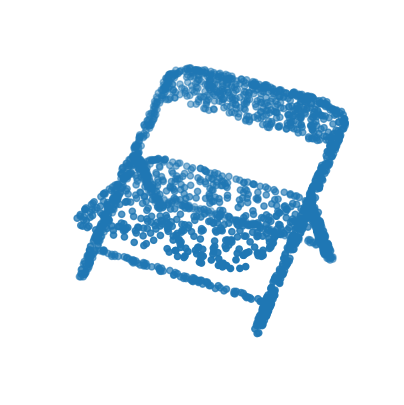

In [ ]:
points = mesh.sample(2048)

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

### Function to parse data

##### Each mesh is loaded and sampled into a point cloud and is returned as a numpy array

In [ ]:
def parse_dataset(num_points = 2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))
    
    for i, folder in enumerate(folders):
        print(f"Processing class {os.path.basename(folder)}")

        # Store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]

        # Gath all files in folder
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)
    
    return (np.array(train_points),
            np.array(test_points),
            np.array(train_labels),
            np.array(test_labels),
            class_map)

### Parse the dataset and process each class

In [ ]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

Processing class bed
Processing class monitor
Processing class night_stand
Processing class dresser
Processing class desk
Processing class bathtub
Processing class toilet
Processing class chair
Processing class table
Processing class sofa


In [ ]:
print(test_points.shape)
print(test_points[0][0])
print(test_labels.shape)

(908, 2048, 3)
[16.1477596  33.69789553  0.69259366]
(908,)


### Augmentation for train dataset

In [ ]:
def augment(points, label):
    # Jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype = tf.float64)
    
    # Shuffle points
    points = tf.random.shuffle(points)

    return points, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))

print(train_dataset)

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

print(train_dataset)

I0000 00:00:1753806843.136096     485 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6078 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:01:00.0, compute capability: 7.5


<_TensorSliceDataset element_spec=(TensorSpec(shape=(2048, 3), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 2048, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


### Functions to build the model

In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size = 1, padding = 'valid')(x)
    x = layers.BatchNormalization(momentum = 0.0)(x)
    return layers.Activation('relu')(x)

def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum = 0.0)(x)
    return layers.Activation('relu')(x)

In [ ]:
class OrthogonalRegulizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg = 0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes = (2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

### Function to create T-net layers

In [ ]:
def tnet(inputs, num_features):

    # Initialize bias as the identity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegulizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalAveragePooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(num_features * num_features,
                     kernel_initializer = 'zeros',
                     bias_initializer = bias,
                     activity_regularizer = reg)(x)
    feat_T = layers.Reshape((num_features, num_features))(x)

    # Apply affine transformation to input features
    return layers.Dot(axes = (2, 1))([inputs, feat_T])

### Create the convolutional neural network

In [ ]:
inputs = keras.Input(shape = (NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalAveragePooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation = 'softmax')(x)

model = keras.Model(inputs = inputs, outputs = outputs, name = 'pointnet')
model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2048, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2048, 32)  │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2048, 32)  │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2048, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 2048, 64)  │      2,112 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048, 64)  │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 2048, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 2048, 512) │     33,280 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048, 512) │      2,048 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 2048, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ activation_2[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 9)         │      1,161 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 3, 3)      │          0 │ dense_2[0][0]   

 Total params: 748,979 (2.86 MB)

 Trainable params: 742,899 (2.83 MB)

 Non-trainable params: 6,080 (23.75 KB)

### Compile and train the model

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ['sparse_categorical_accuracy'])

model.fit(train_dataset, epochs = 20, validation_data = test_dataset)

Epoch 1/20


I0000 00:00:1753806854.017582    2449 service.cc:152] XLA service 0x775328003070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753806854.018035    2449 service.cc:160]   StreamExecutor device (0): Quadro RTX 4000, Compute Capability 7.5
2025-07-29 12:34:14.367426: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753806855.907995    2449 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753806864.568913    2449 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 136ms/step - loss: 43.0401 - sparse_categorical_accuracy: 0.2505 - val_loss: 15009846621372416.0000 - val_sparse_categorical_accuracy: 0.4873
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 35.8267 - sparse_categorical_accuracy: 0.4271 - val_loss: 621359118572516005642240.0000 - val_sparse_categorical_accuracy: 0.4756
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 35.6232 - sparse_categorical_accuracy: 0.4608 - val_loss: 100640030770145716718272512.0000 - val_sparse_categorical_accuracy: 0.4310
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 35.4461 - sparse_categorical_accuracy: 0.5108 - val_loss: 1622817452507267072.0000 - val_sparse_categorical_accuracy: 0.6209
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 35.2746 - sparse_categorical_accuracy: 0.5829 - val_loss: 37.1146 - val_sparse_categorical_accuracy: 0.2420
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 35.1696 - sparse_categor

### Visualize the predictions

2025-07-29 12:38:04.369020: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


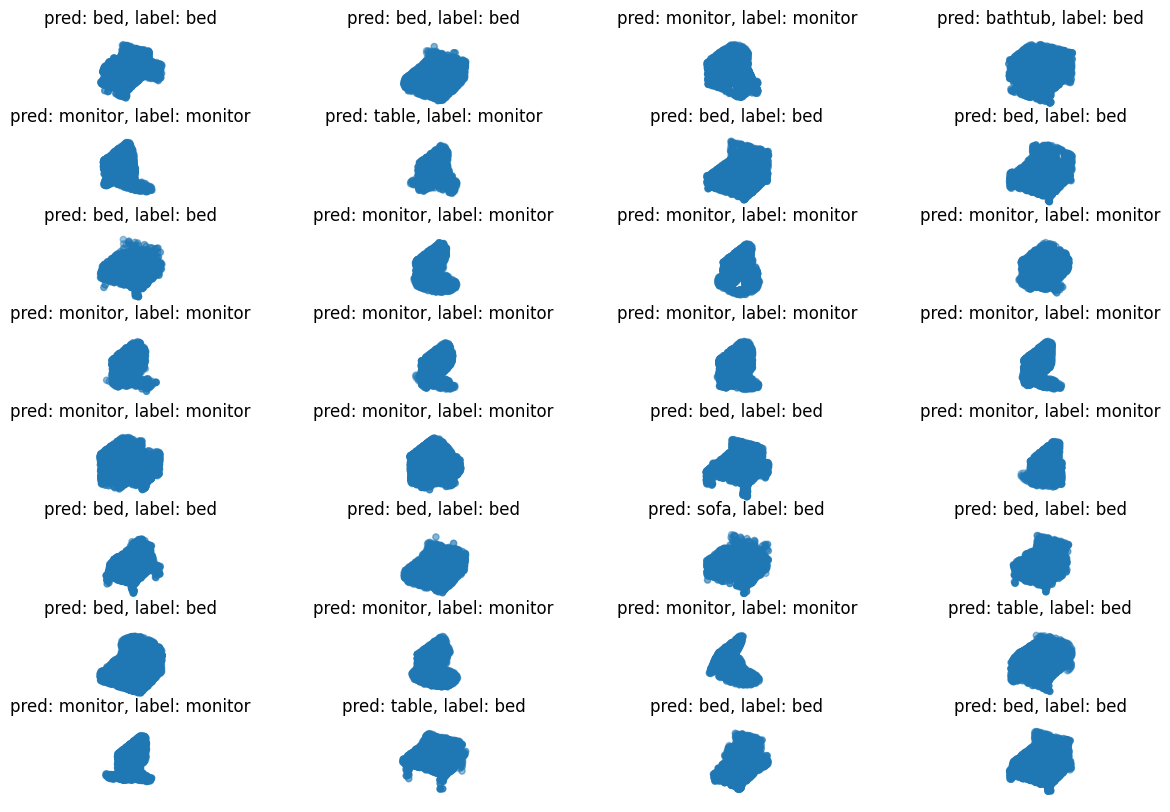

In [ ]:
points, labels = list(test_dataset)[0]
# points = points[:8, ...]
# labels = labels[:8, ...]

# Run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# Plot points with predicted class and label
fig = plt.figure(figsize = (15, 10))

for i in range(points.shape[0]):
    ax = fig.add_subplot(int(np.ceil(points.shape[0] / 4)), 4, i + 1, projection = '3d')
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(f"pred: {CLASS_MAP[int(preds[i])].split('/')[-1]}, label: {CLASS_MAP[int(labels[i])].split('/')[-1]}")
    ax.set_axis_off()

plt.show()